# Variaciones del mismo digito


### En este notebook se observan distintas reconstrucciones del mismo dígito


#### Datos

Se usaron los datos de MNIST para entrenar los modelos y visualizar las variaciones por dígito (genericamente clase).


#### Modelo


Se usaron los modelos de diminesiones 128_2 y 256_128 (intermedia y latente respectivamente) para visualizar.


In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

import experiments.load as load


cvae_0 = load.cvae(lat=64,inter=128,dataset="mnist")

cvae_1 = load.cvae(inter=256,lat=128,dataset="mnist")

cvae_2 = load.cvae(lat=2, inter=128,dataset="mnist")

predictor = load.predictor("mnist")

data =  load.data("mnist")

x_train = data["x_train"]
x_train_1 = data["x_train_1"]
y_train = data["y_train"]
y_train_1 = data["y_train_1"]
x_test = data["x_test"]
y_test  =data["y_test"]

models = load.all_models()

2025-08-21 20:03:12.419568: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 20:03:12.423120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 20:03:12.433537: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755817392.450702 1020561 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755817392.455494 1020561 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755817392.469622 1020561 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Usando mnist como dataset
Encontrados 12 pares de modelos.
encoder_path: ../../trained_models/encoders/en_int_1024_lat_256_fashion.keras
decoder_path: ../../trained_models/decoders/de_int_1024_lat_256_fashion.keras
encoder_path: ../../trained_models/encoders/en_int_1024_lat_256_mnist.keras
decoder_path: ../../trained_models/decoders/de_int_1024_lat_256_mnist.keras
encoder_path: ../../trained_models/encoders/en_int_128_lat_2_fashion.keras
decoder_path: ../../trained_models/decoders/de_int_128_lat_2_fashion.keras
encoder_path: ../../trained_models/encoders/en_int_128_lat_2_mnist.keras
decoder_path: ../../trained_models/decoders/de_int_128_lat_2_mnist.keras
encoder_path: ../../trained_models/encoders/en_int_128_lat_64_fashion.keras
decoder_path: ../../trained_models/decoders/de_int_128_lat_64_fashion.keras
encoder_path: ../../trained_models/encoders/en_int_128_lat_64_mnist.keras
decoder_path: ../../trained_models/decoders/de_int_128_lat_64_mnist.keras
encoder_path: ../../trained_models/en

## Visualizaciones:

Variaciones por dígito de cvae_0


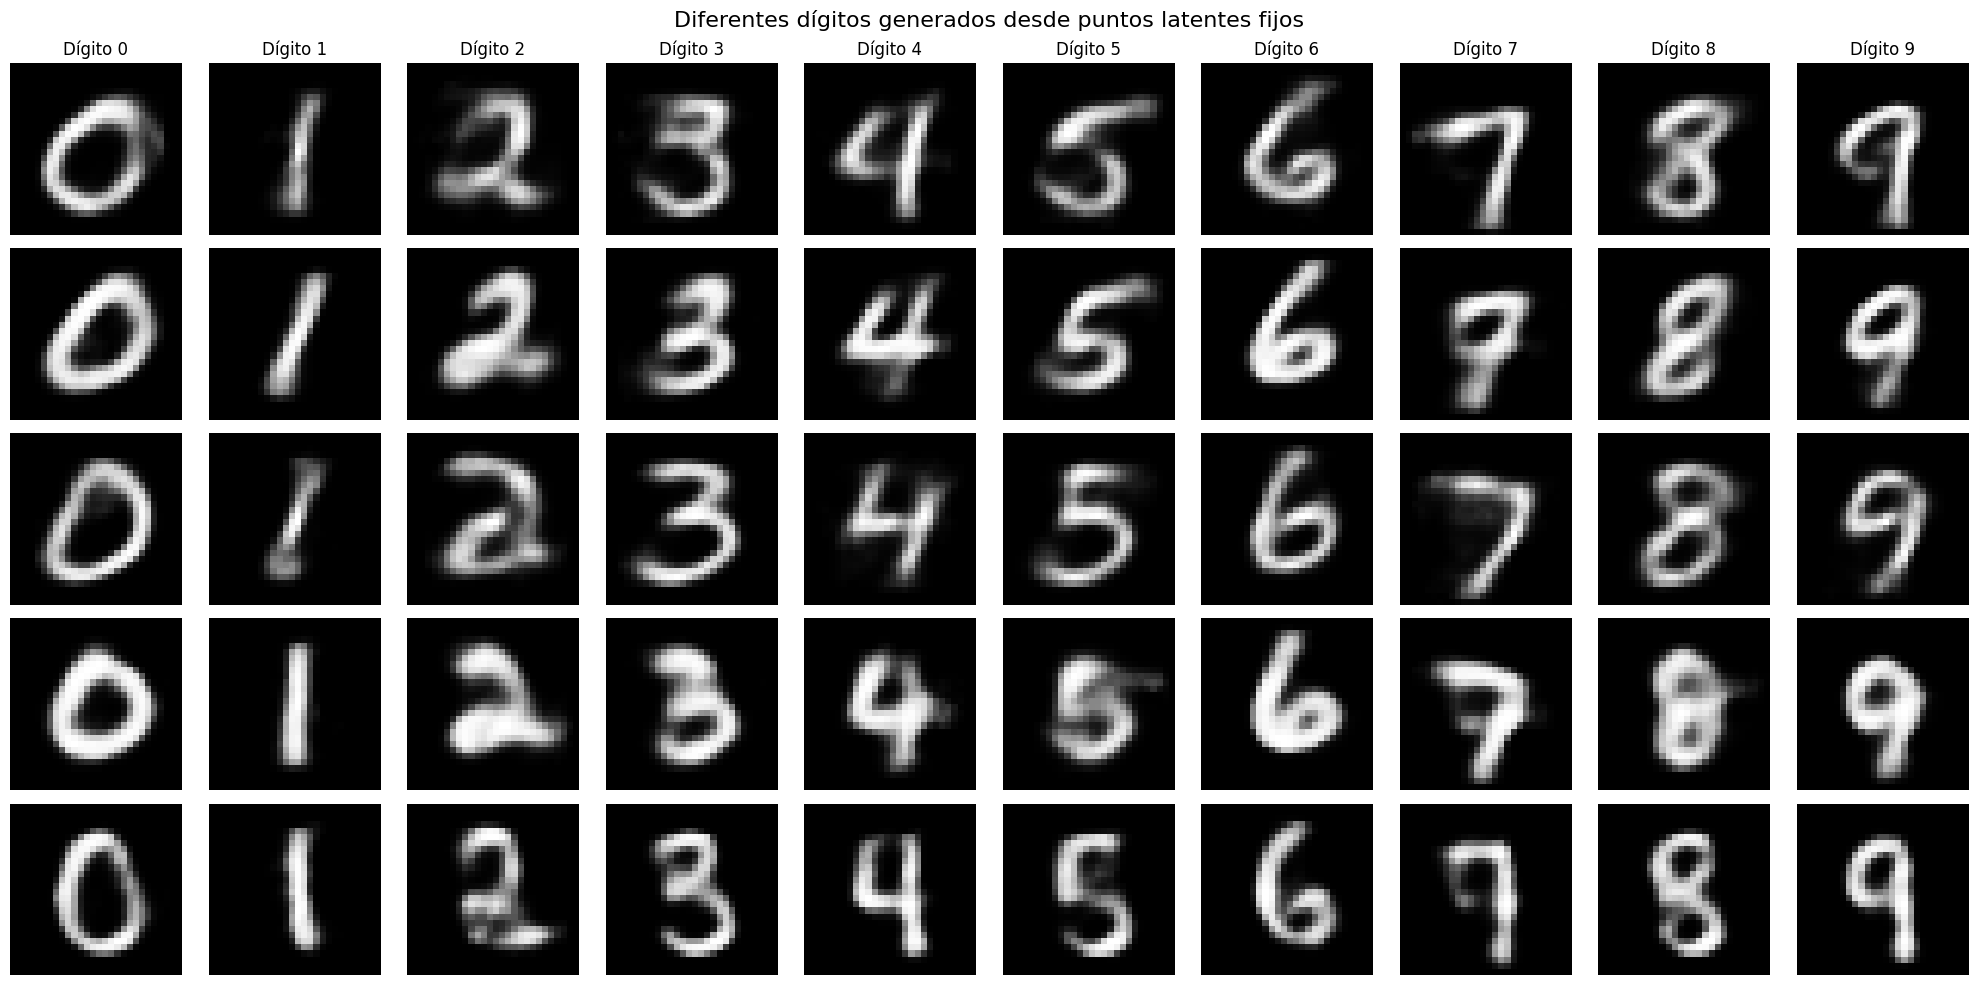

In [4]:
import visualizations.visualizations as vis

puntos=vis.variantes_punto_fijo(cvae=cvae_0)

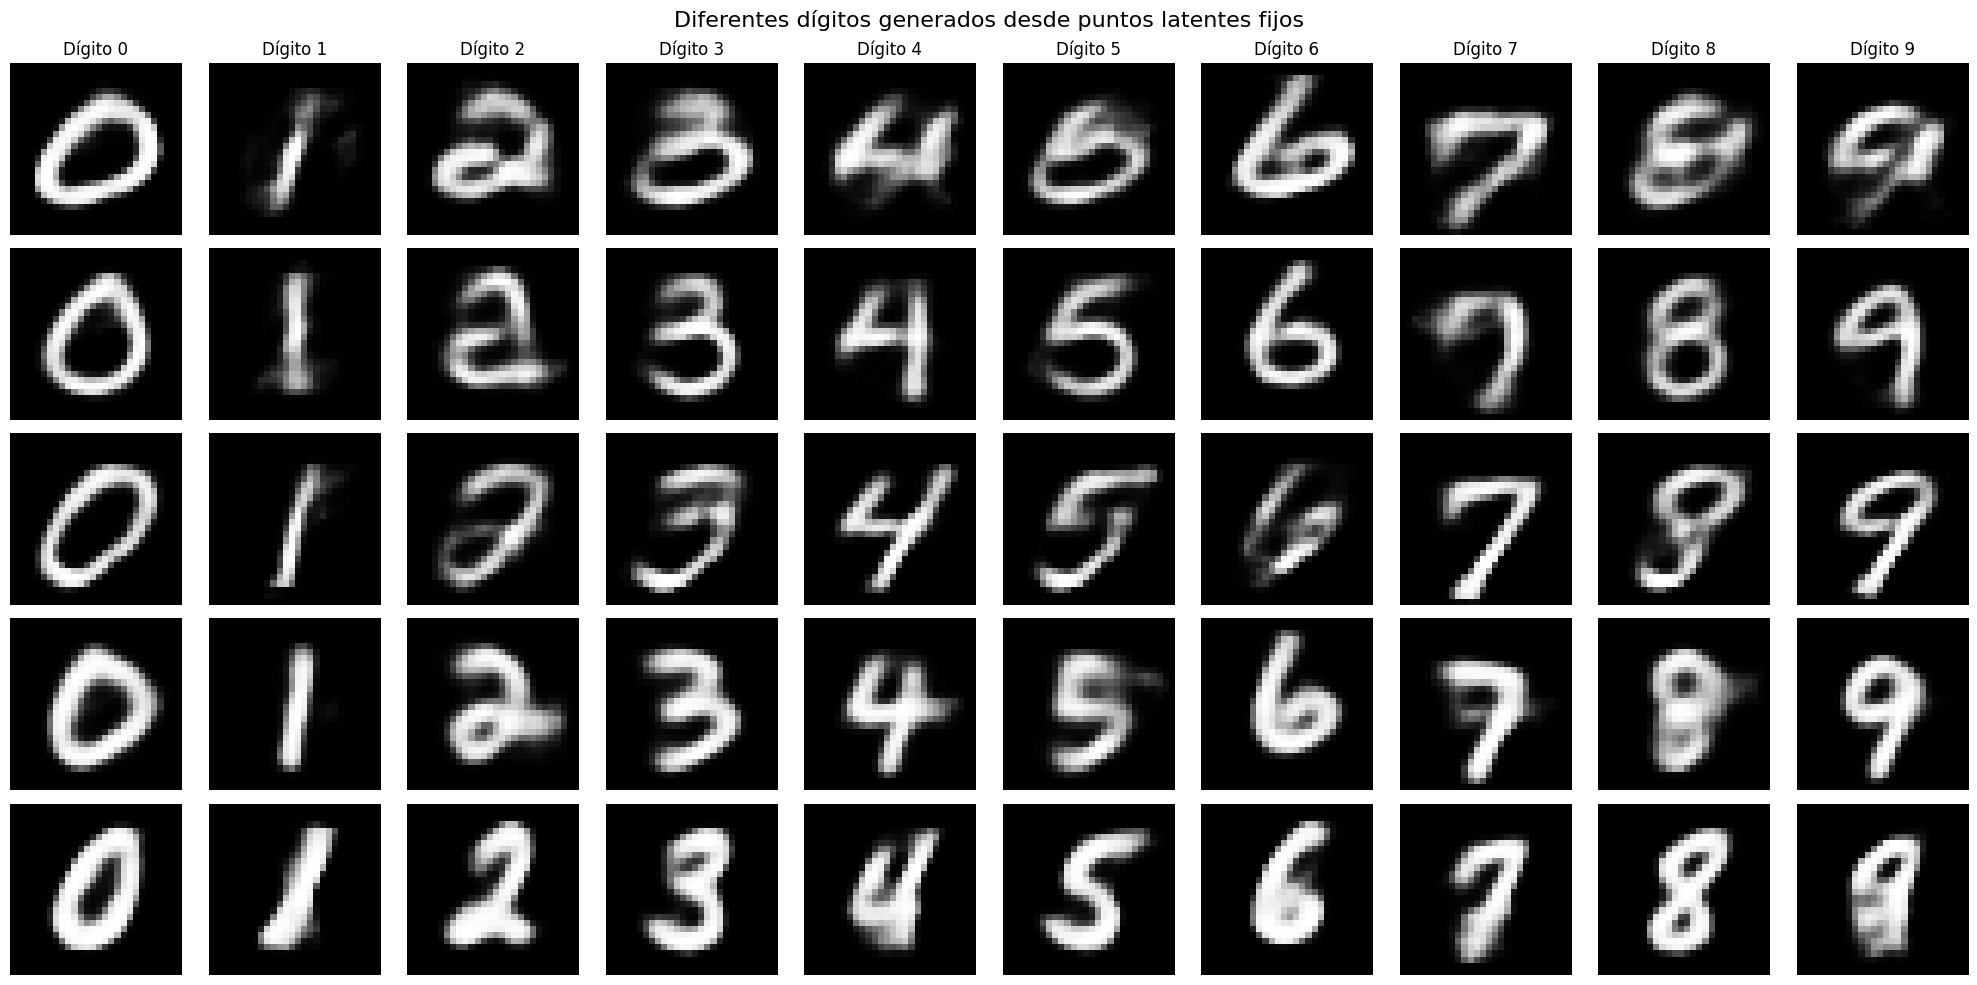

In [5]:
puntos=vis.variantes_punto_fijo(cvae=cvae_1)

Para ambos modelos parece haber una buena reconstruccion de dígitos. Bastante peor en el caso del modelo cvae_1 los modelos fueron entrenados hasta que earystop los freno.
¿Quizas es muy poco entrenamiento? quzias la paciencia del earystop es baja?



## Condiciones anómalas

condición en el decoder y enconder en 0 o aleatoreo


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


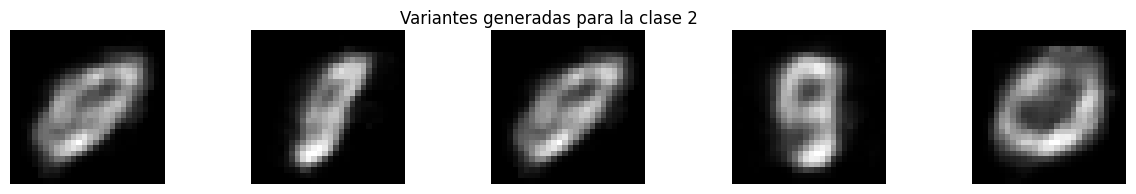

array([[ 0.39417763, -1.00142261],
       [-0.73690373, -0.56313894],
       [ 0.19681557, -1.05563993],
       [-0.12243235,  0.24259914],
       [ 1.26278914, -0.59982121]])

In [ ]:
import visualizaciones.visualizar as vis
import importlib
import numpy as np

importlib.reload(vis)
num_variantes = 5
custom_condition = np.zeros(shape=(num_variantes, 10))
# custom_condition = np.random.uniform(0,1,size=(num_variantes,10))
"""
1) probar poner 0s al encoder.

2) entrenar un encoder sin clases en la entrada (quizas ponerle 0 en la entrada, sino cambiar 
                                                la arquitectura para que no tenga condicion. Verficar si es lo mismo)


"""
print(custom_condition)
vis.variantes(
    cvae=cvae_0,
    condicion_id=2,
    num_variantes=num_variantes,
    custom_condition=custom_condition,
)

En ambos casos se observan figuras caoticas, se aprecia cierta estructura pero no es posible atribuir una clase a las imagenes


Metricas


In [6]:
import numpy as np
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from collections import defaultdict


def evaluar_reconstruccion_por_clase(cvae, x_test, y_test, metric="mse"):
    """
    Evalúa la calidad de reconstrucción para cada clase.

    Args:
        cvae: modelo CVAE entrenado
        x_test: imágenes de prueba (shape: [N, 28, 28])
        y_test: etiquetas one-hot (shape: [N, 10])
        metric: 'mse' o 'bce'

    Returns:
        dict: promedio del error por clase
    """
    errores = defaultdict(list)

    for i in tqdm(range(len(x_test))):
        x = x_test[i : i + 1]  # (1, 28, 28)
        y = y_test[i : i + 1]  # (1, 10)

        # Codificar
        z_mean, _, z = cvae.encoder.predict([x, y], verbose=0)
        # Decodificar
        x_recon = cvae.decoder.predict([z, y], verbose=0)

        # Flatten para comparar
        x_flat = x.flatten()
        x_recon_flat = x_recon.flatten()

        if metric == "mse":
            error = mean_squared_error(x_flat, x_recon_flat)
        elif metric == "bce":
            import tensorflow.keras.losses as losses

            error = losses.binary_crossentropy(x_flat, x_recon_flat).numpy().mean()

        clase = np.argmax(y)
        errores[clase].append(error)

    # Promedio por clase
    resultados = {clase: np.mean(errores[clase]) for clase in errores}
    return resultados

Se usaron 1000 imagenes del dataset MNIST para evaluar el error de reconstrucción por dígito de cada modelo.
Se usan las imagenes originales y la reconstrución para calcular el error cuadratico medio entre ambas figuras.


In [15]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from experiments import load

dataset = "fashion"

data = load.data(dataset=dataset)
models = load.all_models(dataset=dataset)

x_test = data["x_test"]
y_test = data["y_test"]

resultados = []


for m in models:
    resultados.append(evaluar_reconstruccion_por_clase(m, x_test[0:1000], y_test[0:1000], metric="mse"))

for i in range(len(models)):
    print(f"{models[i].name}")
    for clase, error in sorted(resultados[i].items()):
        print(f" Dígito {clase}: error promedio = {error:.3f}")


Usando fashion como dataset
Encontrados 7 pares de modelos.


100%|██████████| 1000/1000 [01:54<00:00,  8.70it/s]

cvae_int_1024_lat_256_fashion
 Dígito 0: error promedio = 0.020
 Dígito 1: error promedio = 0.012
 Dígito 2: error promedio = 0.020
 Dígito 3: error promedio = 0.021
 Dígito 4: error promedio = 0.020
 Dígito 5: error promedio = 0.026
 Dígito 6: error promedio = 0.021
 Dígito 7: error promedio = 0.016
 Dígito 8: error promedio = 0.028
 Dígito 9: error promedio = 0.021
cvae_int_128_lat_2_fashion
 Dígito 0: error promedio = 0.024
 Dígito 1: error promedio = 0.017
 Dígito 2: error promedio = 0.028
 Dígito 3: error promedio = 0.028
 Dígito 4: error promedio = 0.026
 Dígito 5: error promedio = 0.029
 Dígito 6: error promedio = 0.028
 Dígito 7: error promedio = 0.019
 Dígito 8: error promedio = 0.034
 Dígito 9: error promedio = 0.026
cvae_int_128_lat_64_fashion
 Dígito 0: error promedio = 0.020
 Dígito 1: error promedio = 0.015
 Dígito 2: error promedio = 0.021
 Dígito 3: error promedio = 0.023
 Dígito 4: error promedio = 0.020
 Dígito 5: error promedio = 0.027
 Dígito 6: error promedio = 0.0

In [16]:
import matplotlib.pyplot as plt


def plot_error(resultados, ruta=None,title=""):
    valores = list(resultados.values())
    claves = list(resultados.keys())

    # Graficar barras
    bars = plt.bar(claves, valores)

    # Etiquetas encima de cada barra
    for i, bar in enumerate(bars):
        altura = bar.get_height()
        color_fondo = bar.get_facecolor()

        # Elegir blanco o negro según luminosidad del color de la barra
        r, g, b, _ = color_fondo
        color_texto = "black"

        plt.text(
            bar.get_x() + bar.get_width() / 2,  # centrado horizontal
            altura + 0.0015,  # un poco abajo del tope de la barra
            f"{valores[i]:.3f}",
            ha="center",
            va="top",
            color=color_texto,
            fontsize=10,
        )

    plt.xlabel("Dígito")
    plt.ylabel("Error de reconstrucción [MSE]")
    plt.title(f"Reconstrucción promedio por clase modelo: {title}")
    plt.tight_layout()
    if ruta:
        plt.savefig(f"figs/{ruta}.png")
    plt.show()


"""
quizas el error tiene que ver con la variabilidad de cada dígito ("mas formas de dibujar un 8 que mas formas de dibjuar un 1")
¿Como aprovehcar esto para mejorar el aprendizaje?
tal vez se pueda ponderar la loss de reconstruccion en funcion del dígito 
coeficinetes (al principio en 1)->una epoca-> validacion comparando contra estos valores-> ajuste-> epocas---> se "aplana"  este grafico 
el error.
"""

'\nquizas el error tiene que ver con la variabilidad de cada dígito ("mas formas de dibujar un 8 que mas formas de dibjuar un 1")\n¿Como aprovehcar esto para mejorar el aprendizaje?\ntal vez se pueda ponderar la loss de reconstruccion en funcion del dígito \ncoeficinetes (al principio en 1)->una epoca-> validacion comparando contra estos valores-> ajuste-> epocas---> se "aplana"  este grafico \nel error.\n'

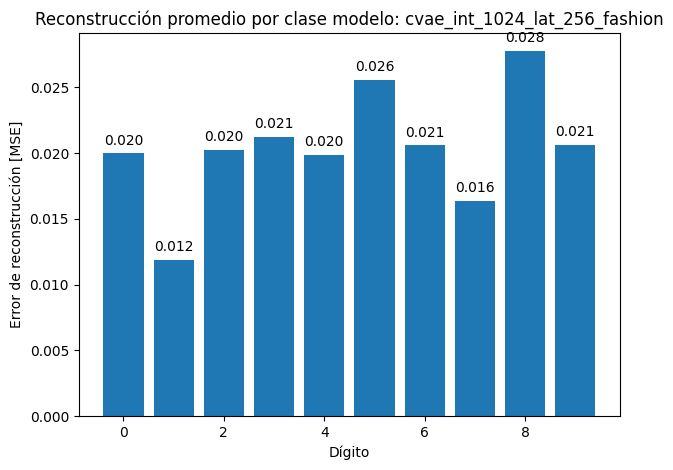

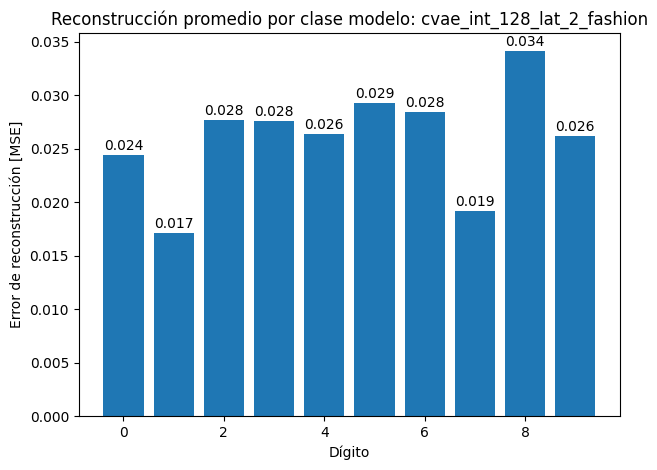

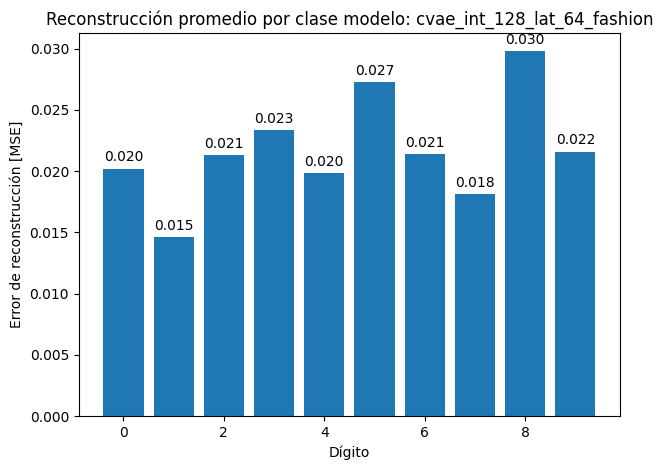

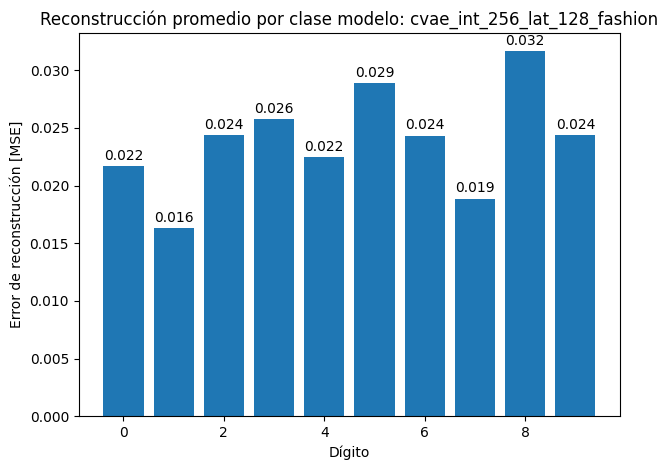

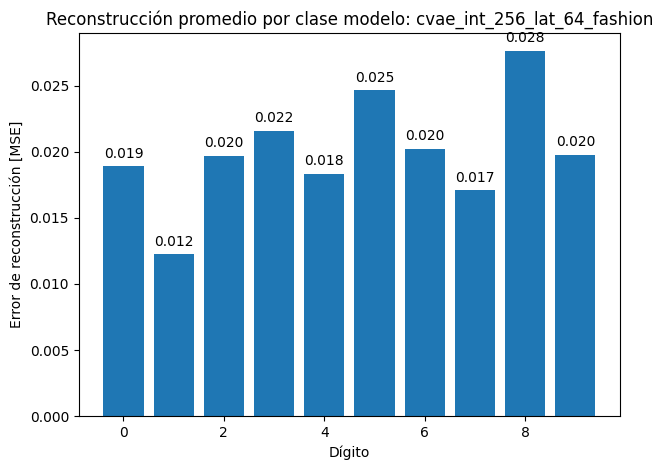

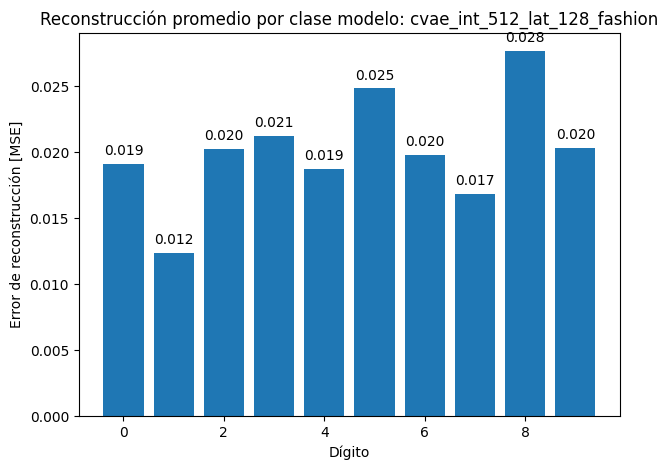

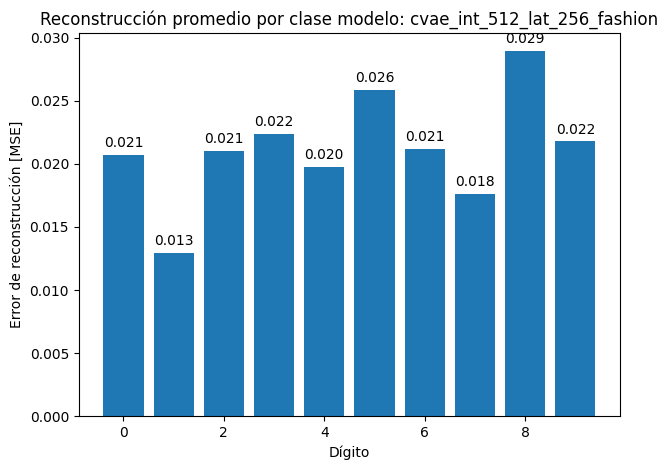

In [17]:
for m,r in zip(models,resultados):
    plot_error(resultados=r, ruta=m.name,title=m.name)




Ambos modelos se comportan de maneras muy similiar, practicamente identicos. --> ¿Es necesario tener modelos tan grandes para esta tarea?

- El bajo error en la reconstrucción del dígito 1 ¿Tendra que ver con la poca "dispersión o variabilidad" para dibujar el número? --> El numero 2 y 8 son los que más error tienen, ¿Más formas de dibujar estos números?


In [ ]:
nombres = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

Con el dataset de fashion-mnist. el error es mas parejo. La clase con menor error la clase de patalones, mientras que la que tiene más error de reconstrucción es la calse de bolsos. Todos los modelos tiene una distribución similar en cuanto en cuanto al error (En ambos datasets).  
No parece haber una mejora de la reconstrucción con más parametros.

## Prueba con más capas

ponemos 2 capas de 64 en lugar de una de 128 para evaluar el error de reconstrucción

In [27]:
from keras.layers import Input, Dense, Concatenate, Reshape
from keras.models import Model
from custom_layers.Sampling import Sampling
from models_definitions.cvae import CVAE 
import tensorflow as tf
from keras.callbacks import EarlyStopping
from experiments import load


condition_dim=(10,)
intermediate_dim=128
latent_dim=2
img_dim=(28,28)
flat_dim = img_dim[0]*img_dim[1]
img_input = Input(shape=(flat_dim,), name="img_input_encoder")
cond_encoder = Input(shape=(condition_dim), name="encoder_condition")
imputs_cocanteados = Concatenate()([img_input, cond_encoder])


x = Dense(96, activation="relu")(imputs_cocanteados) #  96+32=128 un paso intermedio, un escalon más
x = Dense(32, activation="relu")(x) #

z_mean = Dense(latent_dim, name="z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs=[img_input, cond_encoder], outputs=[z_mean, z_log_var, z], name="encoder")



latent_dim = 2
cond_dim=(10,)
intermediate_dim=128
original_shape=(28, 28)
original_dim = original_shape[0] * original_shape[1]

z_inputs = Input(shape=(latent_dim,), name="z_sampling")
cond_decoder = Input(shape=cond_dim, name="decoder_condition")

latent_inputs = Concatenate()([z_inputs, cond_decoder])

x = Dense(32, activation="relu")(latent_inputs)
x = Dense(96, activation="relu")(x)

decoder_outputs = Dense(original_dim, activation="sigmoid")(x)

decoder = Model(inputs=[z_inputs, cond_decoder], outputs=decoder_outputs, name="decoder")


original_dim = 28 * 28
beta = 1.0

data = load.data("fashion")
x_train =  data["x_train"]
y_train = data["y_train"]
x_test =  data["x_test"]
y_test = data["y_test"]
x_val = data["x_val"]
y_val = data["y_val"]



train_dataset = tf.data.Dataset.from_tensor_slices(((x_train, y_train), x_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset = train_dataset.batch(128)

early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
)

val_dataset = tf.data.Dataset.from_tensor_slices(((x_val, y_val), x_val))
val_dataset = val_dataset.batch(128)


cvae = CVAE(encoder=encoder, decoder=decoder, original_dim=original_dim, beta=1)
cvae.compile(optimizer=tf.keras.optimizers.Adam())

cvae.fit(
    train_dataset,
    epochs=1000,
    batch_size=128,
    validation_data=val_dataset,
    callbacks=[early_stopping],
)


resultados_mas_pasos = evaluar_reconstruccion_por_clase(cvae, x_test[0:1000], y_test[0:1000], metric="mse")


print(f"{cvae.name}")
for clase, error in sorted(resultados_mas_pasos.items()):
    print(f" Dígito {clase}: error promedio = {error:.3f}")


Usando fashion como dataset
Epoch 1/1000
430/430 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - kl_loss: 3.3422 - loss: 44.6488 - reconstruction_loss: 41.3167 - val_kl_loss: 3.3923 - val_loss: 30.2106 - val_reconstruction_loss: 26.9056
Epoch 2/1000
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.4135 - loss: 28.4351 - reconstruction_loss: 25.0221 - val_kl_loss: 3.2745 - val_loss: 27.6102 - val_reconstruction_loss: 24.3849
Epoch 3/1000
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.3677 - loss: 26.8810 - reconstruction_loss: 23.5132 - val_kl_loss: 3.2829 - val_loss: 26.8219 - val_reconstruction_loss: 23.6196
Epoch 4/1000
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.3265 - loss: 26.1934 - reconstruction_loss: 22.8670 - val_kl_loss: 3.3573 - val_loss: 26.1959 - val_reconstruction_loss: 22.8984
Epoch 5/1000
430/430 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 3.2820 - loss: 25.7288 - reconstruction_loss: 22.4467 - val_kl_loss: 3.3461 - val_loss: 25.7922 - val_reconstruction_loss: 

100%|██████████| 1000/1000 [01:53<00:00,  8.83it/s]


 Dígito 0: error promedio = 0.025
 Dígito 1: error promedio = 0.018
 Dígito 2: error promedio = 0.028
 Dígito 3: error promedio = 0.028
 Dígito 4: error promedio = 0.027
 Dígito 5: error promedio = 0.030
 Dígito 6: error promedio = 0.029
 Dígito 7: error promedio = 0.019
 Dígito 8: error promedio = 0.034
 Dígito 9: error promedio = 0.026


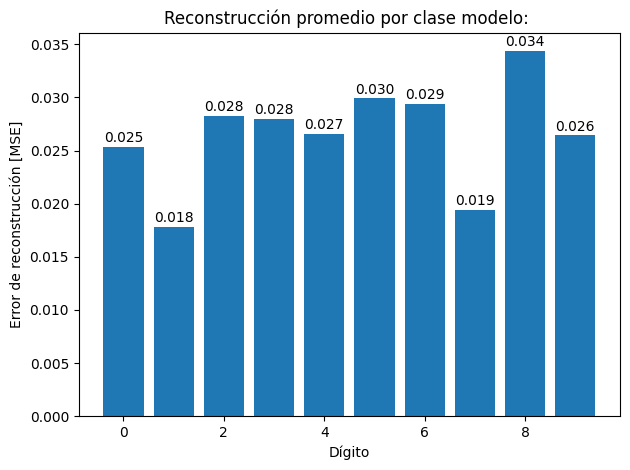

In [28]:
plot_error(resultados_mas_pasos, ruta="cvae_96_32_2_fashion",title=cvae.name)